### Demand Forecasting - what is the most common number of days between order creation date and requested delivery date?

In [3]:
import pyodbc
conn = pyodbc.connect("Driver={ODBC Driver 13 for SQL Server};Server=yetidb01.database.windows.net;database=YETISQLDW01;uid=ezeng;PWD=Ed1tH2EnG#")
cursor = conn.cursor()

In [4]:
query = ("""
WITH ZVA05 AS
(
	(
		SELECT * FROM [EDW].[sap_zva05_fct] 
		WHERE SL_Status = 'Active SL' 
		AND Reason_for_Rejection IS NULL
		AND SalesOffice = 'STD' 
        AND Order_Type NOT IN ('ZARF', 'ZARM', 'ZEG2', 'ZERF', 'ZERM', 'ZRE')
	) UNION (
		SELECT * FROM [EDW].[sap_zva05_fct] 
		WHERE SL_Status = 'Active SL'
		AND Reason_for_Rejection IS NULL
		AND SalesOffice = 'HYB'
		AND Order_Type NOT IN ('ZARF', 'ZARM', 'ZEG2', 'ZERF', 'ZERM', 'ZRE')
	)
) SELECT Sales_document, Sold_to_Party, SD_Item, SalesOffice, Order_Type, Product_Hierarchy, Material_Description, Unit_Price, Document_Date, Goods_Issue_Date, Overall_Credit_Status, Delivery_Block, Billing_Block, Overall_Delivery_status_Item, Overall_Order_Status_Header, Overall_Order_Status_Item, Block_flag, Line_Req_Deliv_Date, ConfirmationStatus, Confirmed_Line_Quantity, Confirmed_Line_Value, Net_Value, Overall_Credit_Status_Desc, Net_Value_Actual, days_stale
FROM ZVA05
ORDER BY Document_Date ASC;
""")

In [ ]:
import pandas as pd
import numpy as np
import copy

aggregate = pd.read_sql(query, conn)

In [5]:
aggregate.shape

(630018, 25)

In [6]:
aggregate.columns

Index(['Sales_document', 'Sold_to_Party', 'SD_Item', 'SalesOffice',
       'Order_Type', 'Product_Hierarchy', 'Material_Description', 'Unit_Price',
       'Document_Date', 'Goods_Issue_Date', 'Overall_Credit_Status',
       'Delivery_Block', 'Billing_Block', 'Overall_Delivery_status_Item',
       'Overall_Order_Status_Header', 'Overall_Order_Status_Item',
       'Block_flag', 'Line_Req_Deliv_Date', 'ConfirmationStatus',
       'Confirmed_Line_Quantity', 'Confirmed_Line_Value', 'Net_Value',
       'Overall_Credit_Status_Desc', 'Net_Value_Actual', 'days_stale'],
      dtype='object')

In [7]:
aggregate.head(5)

,Sales_document,Sold_to_Party,SD_Item,SalesOffice,Order_Type,Product_Hierarchy,Material_Description,Unit_Price,Document_Date,Goods_Issue_Date,...,Overall_Order_Status_Item,Block_flag,Line_Req_Deliv_Date,ConfirmationStatus,Confirmed_Line_Quantity,Confirmed_Line_Value,Net_Value,Overall_Credit_Status_Desc,Net_Value_Actual,days_stale
0,0010000013,0000101539,000010,STD,OR,1011122022162000,Hopper Flip 12 Field Tan,189.72,2017-02-04,2017-03-28,...,C,None,2017-03-01,Confirmed,3.0,569.17,569.17,No Credit Issue,569.17,FALSE
1,0010000012,0000101539,000010,STD,OR,1011122022162000,Hopper Flip 12 Field Tan,189.72,2017-02-04,2017-03-28,...,C,None,2017-03-01,Confirmed,3.0,569.17,569.17,No Credit Issue,569.17,FALSE
2,0010000011,0000101539,000010,STD,OR,1011122022162000,Hopper Flip 12 Field Tan,189.72,2017-02-04,2017-03-28,...,C,None,2017-03-01,Confirmed,3.0,569.17,569.17,No Credit Issue,569.17,FALSE
3,0010000000,0000101539,000010,STD,OR,1011122022162000,Hopper Flip 12 Field Tan,189.72,2017-02-04,2017-03-28,...,C,None,2017-03-01,Confirmed,1.0,189.72,189.72,No Credit Issue,189.72,FALSE
4,0010000009,0000101539,000010,STD,OR,1011122022162000,Hopper Flip 12 Field Tan,189.72,2017-02-04,2017-03-28,...,C,None,2017-03-01,Confirmed,3.0,569.17,569.17,No Credit Issue,569.17,FALSE


In [10]:
aggregate.isnull().sum()

Sales_document                       0
Sold_to_Party                        0
SD_Item                              0
SalesOffice                          0
Order_Type                           0
Product_Hierarchy                10186
Material_Description                 0
Unit_Price                           0
Document_Date                        0
Goods_Issue_Date                     0
Overall_Credit_Status            40368
Delivery_Block                  622672
Billing_Block                   629774
Overall_Delivery_status_Item     29865
Overall_Order_Status_Header          0
Overall_Order_Status_Item            3
Block_flag                      612901
Line_Req_Deliv_Date                  0
ConfirmationStatus                   0
Confirmed_Line_Quantity              0
Confirmed_Line_Value                 0
Net_Value                            0
Overall_Credit_Status_Desc           0
Net_Value_Actual                     0
days_stale                           0
dtype: int64

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

def plot_waiting_period(X, kde_bool, x_lo, x_hi):
    plt.figure(figsize=(15,8))
    sns.set_style('darkgrid')
    fig = sns.distplot(X, kde=kde_bool, hist_kws=dict(edgecolor='k',linewidth=.5))
    plt.xlim(x_lo, x_hi)

In [1]:
# add new column waiting_days to count intervals
aggregate['waiting_days'] = aggregate.apply(lambda _: '', axis=1)
aggregate.head(5)

NameError: name 'aggregate' is not defined

In [ ]:
import sys
import time
def update_waiting_days():
    df = copy.deepcopy(aggregate)
    for row_index, row in df.iterrows():
        interval = df.loc[row_index,'Line_Req_Deliv_Date'] - df.loc[row_index,'Document_Date']
        df.loc[row_index,'waiting_days'] = interval.days
        if row_index%10000 == 0:
            sys.stdout.write('\r'+"{0:.3%}".format(row_index/len(aggregate)))
            sys.stdout.flush()
    return df
df = update_waiting_days()

In [13]:
df.tail(5)

,Sales_document,Sold_to_Party,SD_Item,SalesOffice,Order_Type,Product_Hierarchy,Material_Description,Unit_Price,Document_Date,Goods_Issue_Date,...,Block_flag,Line_Req_Deliv_Date,ConfirmationStatus,Confirmed_Line_Quantity,Confirmed_Line_Value,Net_Value,Overall_Credit_Status_Desc,Net_Value_Actual,days_stale,waiting_days
622769,0011249157,0000107560,000050,STD,OR,2013143013032900,Rambler 20 oz Charcoal w/ MS Lid,18.76,2018-06-10,2018-06-13,...,Block Issue,2018-06-10,Confirmed,6.0,112.53,112.53,No Credit Issue,112.53,TRUE,0
622770,0011249157,0000107560,000040,STD,OR,2013143013033400,Rambler 20 oz w/MS Lid Sky Blue,18.76,2018-06-10,2018-06-13,...,Block Issue,2018-06-10,Unconfirmed,0.0,0.00,0.00,No Credit Issue,112.53,TRUE,0
622771,0011249157,0000107560,000020,STD,OR,2013143013031000,Rambler 20 oz w/MS Lid White,18.76,2018-06-10,2018-06-13,...,Block Issue,2018-06-10,Confirmed,6.0,112.53,112.53,No Credit Issue,112.53,TRUE,0
622772,0011249157,0000107560,000010,STD,OR,2013143013031500,Rambler 20 oz w/MS Lid Seafoam,18.76,2018-06-10,2018-06-13,...,Block Issue,2018-06-10,Confirmed,6.0,112.53,112.53,No Credit Issue,112.53,TRUE,0
622773,0011249157,0000107560,000030,STD,OR,2013143013033200,Rambler 20 oz w/MS Lid LE Coral,18.76,2018-06-10,2018-06-13,...,Block Issue,2018-06-10,Confirmed,6.0,112.53,112.53,No Credit Issue,112.53,TRUE,0


In [25]:
df['waiting_days'].describe()  # negative intervals

count    621303.000000
mean         18.357062
std          32.183172
min        -366.000000
25%           0.000000
50%           0.000000
75%          29.000000
max         387.000000
Name: waiting_days, dtype: float64

In [26]:
len(df)

621303

In [29]:
type(df)

pandas.core.frame.DataFrame

In [31]:
# local copy
df.to_csv("df.csv",float_format)

In [121]:
# store local var
df_zva05 = df

Stored 'df_zva05' (DataFrame)


In [408]:
df_zva05.loc[df_zva05['waiting_days']>=0]['waiting_days'].describe()

count    591850.000000
mean         19.662274
std          31.966221
min           0.000000
25%           0.000000
50%           0.000000
75%          32.000000
max         387.000000
Name: waiting_days, dtype: float64

In [486]:
print("number of records with 0-day wait period:")
len(df_zva05.loc[df_zva05['waiting_days']==0])

number of records with 0-day wait period:


316523

In [487]:
print("total number of records:")
len(df)

total number of records:


622774

In [488]:
print("number of records with at least 1 day of wait period:")
len(df[df['waiting_days'] > 0])

number of records with at least 1 day of wait period:


275327

### Visualize the intervals between requested delivery dates and order dates

In [85]:
# exclude records with negative intervals
df_corrected = df[df['waiting_days'] > 0]
df_corrected['waiting_days'].median()

35.0

In [454]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

def plot_waiting_period(X, kde_bool, x_lo, x_hi, mean_line=None, median_line=None, bins_=None):
    plt.figure(figsize=(15,8))
    sns.set_style('darkgrid')
    fig = sns.distplot(X, kde=kde_bool,bins=bins_,hist_kws=dict(edgecolor='k',linewidth=.5))
    if mean_line:
        plt.axvline(x=mean_line,color='green',linestyle='dashed',alpha=0.8)
    if median_line:
        plt.axvline(x=median_line,color='purple',linestyle='dotted',alpha=0.8)
    plt.xlim(x_lo, x_hi)

Overall stat for wait_days (interval > 0)


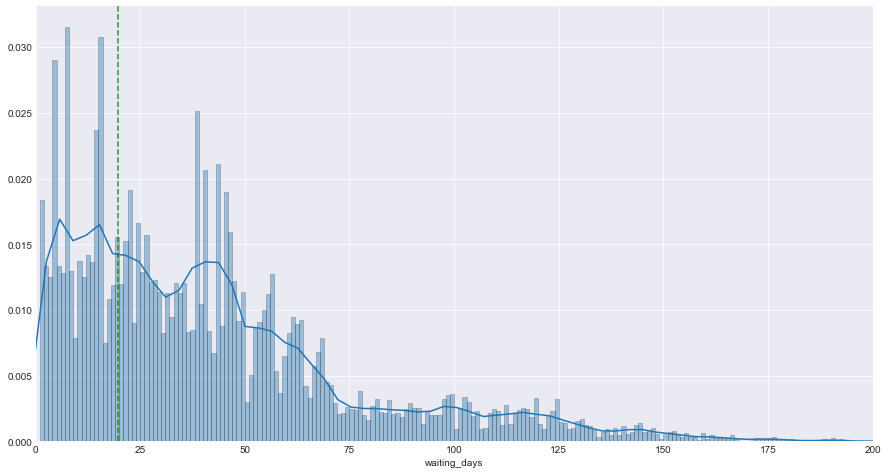

In [495]:
print("Overall stat for wait_days (interval > 0)")
plot_waiting_period(df_corrected['waiting_days'], True, 0, 200, mean_line=19.662274, bins_= [i for i in range(300)])

In [455]:
# What is the most common interval for STD/HYB customers? Including 0 days datapoints
def breakdown_salesoffice_intervals(SalesOffice, include_zero_bool, lo=0, hi=60, mean_line=None, median_line=None,bins_=None):
    df_mini = df[df['waiting_days'] >= 0] if include_zero_bool else df[df['waiting_days'] > 0]
    grouped = df_mini['waiting_days'].groupby(df_mini['SalesOffice'])
    X = df_mini.loc[df['SalesOffice'] == SalesOffice]['waiting_days']
    plot_waiting_period(X,False,lo,hi,mean_line,median_line,bins_)
    
    return df_mini.describe()

In [456]:
df.loc[df['waiting_days']>=0].groupby(df['SalesOffice'])['waiting_days'].describe()

,count,mean,std,min,25%,50%,75%,max
SalesOffice,,,,,,,,
HYB,44287.0,14.00779,25.914710,0.0,0.0,7.0,14.0,220.0
STD,547563.0,20.11961,32.363175,0.0,0.0,0.0,34.0,387.0


Waiting period count (including zero days) for STD


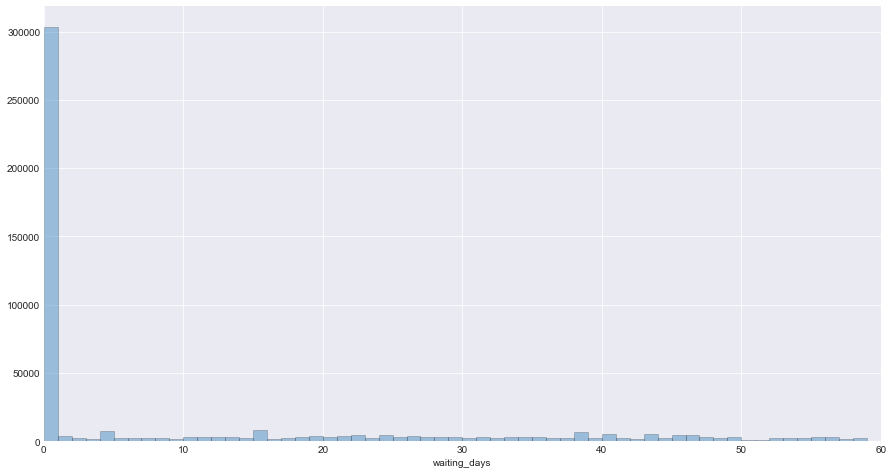

In [483]:
breakdown_salesoffice_intervals('STD',True,0,60,bins_=[i for i in range(60)])
print("Waiting period count (including zero days) for STD")

Waiting period count (including zero days) for HYB


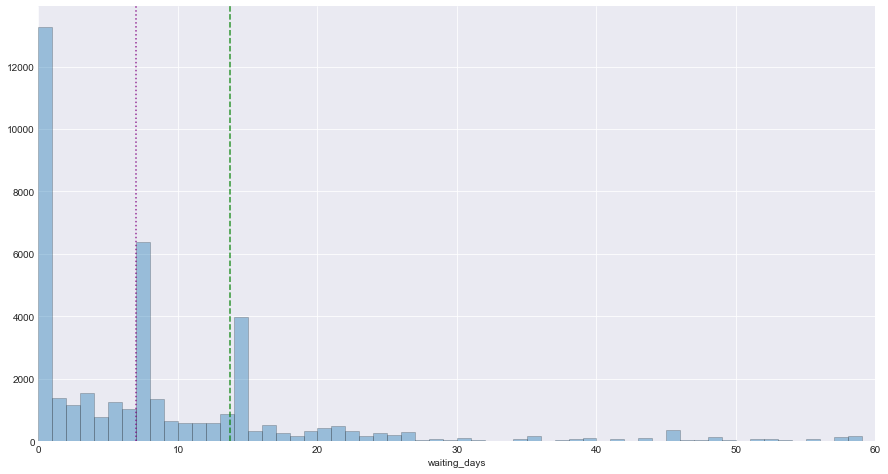

In [481]:
breakdown_salesoffice_intervals('HYB', True, 0, 60,mean_line=13.7,median_line=7,bins_=[i for i in range(60)])
print("Waiting period count (including zero days) for HYB")

In [70]:
# What is the common interval for STD/HYB customers? Excluding 0 days datapoints
df_corrected['waiting_days'].groupby(df_corrected['SalesOffice']).describe()

,count,mean,std,min,25%,50%,75%,max
SalesOffice,,,,,,,,
HYB,30825.0,19.562109,27.959768,1.0,7.0,9.0,17.0,220.0
STD,244239.0,45.112013,34.946561,1.0,20.0,38.0,60.0,387.0


Waiting period counts (excluding zero days) for STD dealers


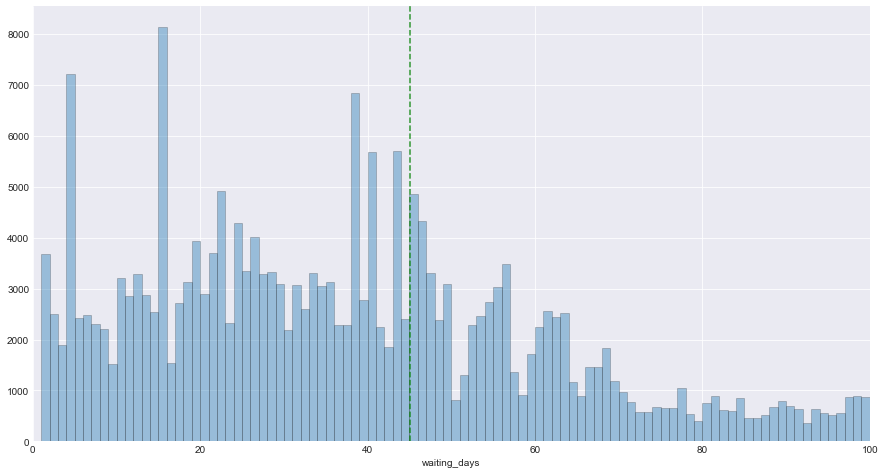

In [496]:
breakdown_salesoffice_intervals('STD', False, 0, 100, mean_line=45.112013,bins_=[i for i in range(300)])
print("Waiting period counts (excluding zero days) for STD dealers")

Wait period counts (excluding zero days) for HYB dealers


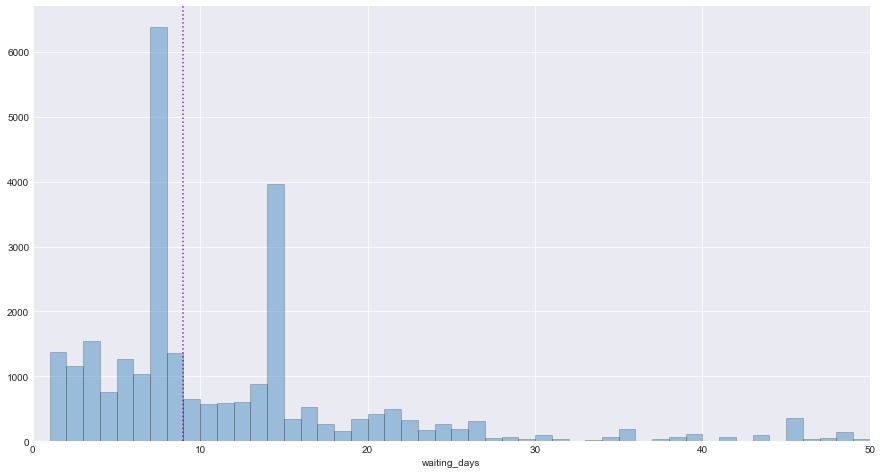

In [497]:
breakdown_salesoffice_intervals('HYB',False,0,50,median_line=9,bins_=[i for i in range(300)])  # median, NOT mean
print("Wait period counts (excluding zero days) for HYB dealers")

In [4]:
asap_group = df[df['waiting_days']==0]
asap_group.describe()

,SD_Item,Product_Hierarchy,Unit_Price,Confirmed_Line_Quantity,Confirmed_Line_Value,Net_Value,Net_Value_Actual,waiting_days
count,315335.000000,3.124190e+05,315335.000000,315335.000000,3.153350e+05,315335.000000,3.153350e+05,315335.0
mean,92.288138,1.573280e+15,96.615205,14.611883,5.125195e+02,37.400989,5.183426e+02,0.0
std,99.537444,4.973814e+14,101.313522,122.141822,5.575661e+03,522.418782,5.590584e+03,0.0
min,10.000000,1.010101e+15,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.0
25%,30.000000,1.010101e+15,17.990000,2.000000,1.199600e+02,2.000000,1.199800e+02,0.0
50%,60.000000,2.013143e+15,23.990000,6.000000,2.144900e+02,6.000000,2.158800e+02,0.0
75%,120.000000,2.013143e+15,194.990000,12.000000,3.726800e+02,12.000000,3.778200e+02,0.0
max,1200.000000,2.013193e+15,1104.990000,20958.000000,2.305360e+06,126743.500000,2.305360e+06,0.0


In [5]:
waiting_group = df[df['waiting_days']>0]
waiting_group.describe()

,SD_Item,Product_Hierarchy,Unit_Price,Confirmed_Line_Quantity,Confirmed_Line_Value,Net_Value,Net_Value_Actual,waiting_days
count,275064.000000,2.680300e+05,275064.000000,275064.000000,275064.000000,275064.000000,275064.000000,275064.000000
mean,104.290896,1.617836e+15,89.771429,21.707592,705.012408,321.438641,717.486700,42.248768
std,117.748553,4.898662e+14,94.586023,97.203313,2354.578578,1473.090244,2361.589214,35.170482
min,1.000000,2.000000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,30.000000,1.011122e+15,17.990000,2.000000,125.940000,6.000000,125.940000,15.000000
50%,70.000000,2.013143e+15,23.990000,6.000000,227.490000,71.940000,227.490000,35.000000
75%,130.000000,2.013143e+15,181.990000,12.000000,441.990000,227.490000,454.980000,56.000000
max,1430.000000,2.013193e+15,844.990000,5544.000000,134219.100000,134219.100000,134219.100000,387.000000
